## Lab: Cart Pole using OpenAI gym
## RL Basics and Simple Policy

### University of Virginia
### Reinforcement Learning
#### Last updated: May 26, 2025

---


#### Instructions:  

Carefully read the notes below and run the provided code. Answer each question clearly and show all results.

#### TOTAL POINTS: 10

---

### Agent and Environment

It is essential for the agent to have a way to get the next state and reward from the environment.

Sometimes it is possible for the agent to interact with environment in real life, but often this is expensive / dangerous / impossible.

We use models and simulators in this latter case.

For this reason, the Gym package is useful in RL

**Note**: Going forward, the fork [gymnasium](https://gymnasium.farama.org/) will maintain OpenAI gym.  
We will be using `gymnasium` but will still refer to the environment as `gym` when it doesn't cause confusion.

---

### Introduction to Gym

Gym is a toolkit for developing and comparing RL algorithms.

It comes with many pre-built environments which have functionality to emulate physical environments.

Users can build their own custom environments. See [here](https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e#:~:text=8%20min%20read-,Create%20custom%20gym%20environments%20from%20scratch%20%E2%80%94%20A%20stock%20market%20example,Atari%20games%20to%20experiment%20with.) for example.

---

### Cart Pole Problem

The **CartPole** problem has a small state space and action space, so it's popular for illustrating ideas.

Pole is attached to a cart on a frictionless track.

Pole starts upright

**Goal** is to keep pole from falling over

Control system by applying **force** -1 or +1 to cart.

**Reward** of +1 for each timestep the pole remains upright

**Episode** ends when pole is more than 12 degrees from vertical, or cart moves more than 2.4 units from center

CartPole-v1 defines *solving* as getting average reward of 195.0 over 100 consecutive trials.

<img src="https://github.com/bmcgregor22/reinforcement_learning_online_msds/blob/main/01_rl_fundamentals/cartpole.png?raw=1" alt="drawing" width="150"/>

---

### Setup and First Steps

This notebook can be easily run on [Google Colab](https://colab.research.google.com/)

In [125]:
! pip install gymnasium

We can use [renderlab](https://github.com/ryanrudes/renderlab/tree/main) to visualize *results*

In [126]:
! pip install renderlab

In [127]:
import gymnasium as gym
import renderlab as rl

Load the environment

In [128]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")

state = env.reset(seed=314)
print(state)

(array([0.04225422, 0.02126478, 0.02520455, 0.00700802], dtype=float32), {})


Given the state, we take an action. The next state comes from the environment, which is encoded in `gym`.

The first element holds components:   
[0]: cart horizontal position (0.0 = center)  
[1]: velocity (positive means right)  
[2]: angle of the pole (0.0 = vertical)  
[3]: pole's angular velocity (positive means clockwise)

In [129]:
# state space number of components
env.observation_space.shape[0]

4

The action space consists of two options:

[0]: move cart left   
[1]: move cart right

In [7]:
env.action_space

Discrete(2)

Let's take an action, draw a sample and look at the results.

In [130]:
# move right
action = 1

# take a step and get next state, reward from environment
state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print('state', state)
print('reward', reward)
print('done', done)
print('info', info)

state [ 0.04267951  0.21601637  0.02534471 -0.27761722]
reward 1.0
done False
info {}


**Note about DONE**  
We need to understand if the episode is done after taking action  

The API now gives more detail on this variable, which may reach `done` state for two reasons:  
- **terminated**=True if environment terminates (eg. due to task completion, failure etc.)  
- **truncated**=True if episode truncates due to a time limit or a reason that is not defined as part of the task MDP.

**Run several steps by taking random actions**  

In [131]:
state = env.reset(seed=314)
for _ in range(5):
    print(env.step(env.action_space.sample())) # take a random action

(array([ 0.04267951, -0.1742094 ,  0.02534471,  0.30753553], dtype=float32), 1.0, False, False, {})
(array([ 0.03919533, -0.36968315,  0.03149542,  0.6081025 ], dtype=float32), 1.0, False, False, {})
(array([ 0.03180166, -0.56523097,  0.04365747,  0.9105369 ], dtype=float32), 1.0, False, False, {})
(array([ 0.02049704, -0.3707261 ,  0.06186821,  0.63188887], dtype=float32), 1.0, False, False, {})
(array([ 0.01308252, -0.17651942,  0.07450598,  0.3593138 ], dtype=float32), 1.0, False, False, {})


**Run an epoch by taking random actions. Visualize the results.**  

In [132]:
env = rl.RenderFrame(env, "./output")

observation, info = env.reset()

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1757115104.4281669.mp4, 720000 bytes wanted but 0 bytes read,at frame 17/18, at time 0.57/0.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                   

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


**Reward and Episode**  

For each time step that the cart keeps the pole balanced, it earns reward 1.

If the pole tilts too much or if the cart moves off screen, `reward=0` and `done=True` (the episode will end).

When the episode ends, a new episode may begin. The process learns cumulatively from each episode.

---

#### 1) Defining a function that runs a simple policy
**(POINTS: 1)**

When the pole leans left (negative angle), move left. When the pole leans right (positive angle), move right.  

The function should take the state and return an action. Test that it works properly.  

In [133]:
# simple policy: move left if pole leans left, move right if pole leans right
def simple_policy(state):
    if state[2] < 0:   # theta is negative (leans left)
        return 0       # move left
    else:              # theta is positive (leans right)
        return 1       # move right

In [134]:
# env.reset() returns a tuple (observation, info)
observation, info = env.reset()
action = simple_policy((observation))
print(action)

1


#### 2) Simulating episodes with the simple policy  

2a) **(POINTS: 2)** Run 1000 episodes each with 100 time steps. Use the `simple_policy` for taking actions.  
Each time step will call the `step()` method to get the next state and reward. Produce a boxplot of the rewards from each episode.

In [137]:
episode_rewards = []

# Run 1000 episodes, each with up to 100 steps
for episode in range(1000):
    obs, info = env.reset()
    total_reward = 0
    for t in range(100):
        action = simple_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:   # stop early if episode ends
            break
    episode_rewards.append(total_reward)

env.close()


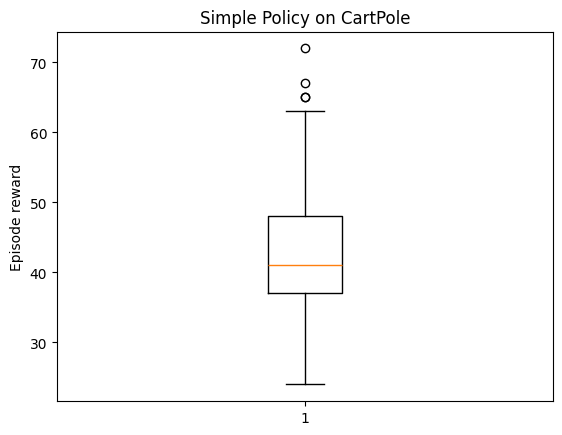

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# make a boxplot of rewards
plt.boxplot(episode_rewards)
plt.ylabel("Episode reward")
plt.title("Simple Policy on CartPole")
plt.show()


2b) **(POINTS: 1)** Is this policy able to solve the cart pole problem? Explain your answer.

No, this policy was not able to solve the cart pole problem. To solve the problem, it needs to collect 195 rewards over 100 consecutive trials. The box plot shows the mean reward is around 40, and the max reward is under 70.  To solve the problem, we need to incorporate the cart's position and velocity.  The cart was only able to adjust the angle, so it could not make adjustments to the other variables that would result in a successful average reward above 195.

#### 3) From Question [2], what is the mean and maximum reward (roughly)?
**(POINTS: 1)**

In [139]:

print("Mean reward:", np.mean(episode_rewards))
print("Max reward:", np.max(episode_rewards))

Mean reward: 42.049
Max reward: 72.0


#### 4) Reversed Simple Policy
**(POINTS: 2)**

What happens if you reverse the simple policy, moving left when the pole leans right, and moving right when the pole leans left? This is not a good idea, but it's instructive. To show the result, produce the boxplot from before, and calculate the mean reward.

In [140]:
# reverse_policy: move left if pole leans right, move right if pole leans left
def reverse_policy(state):
    if state[2] < 0:   # theta is negative (leans left)
        return 1       # move right
    else:              # theta is positive (leans right)
        return 0       # move left

In [141]:
episode_rewards = []

# Run 1000 episodes, each with up to 100 steps
for episode in range(1000):
    obs, info = env.reset()
    total_reward = 0
    for t in range(100):
        action = reverse_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:   # stop early if episode ends
            break
    episode_rewards.append(total_reward)

env.close()

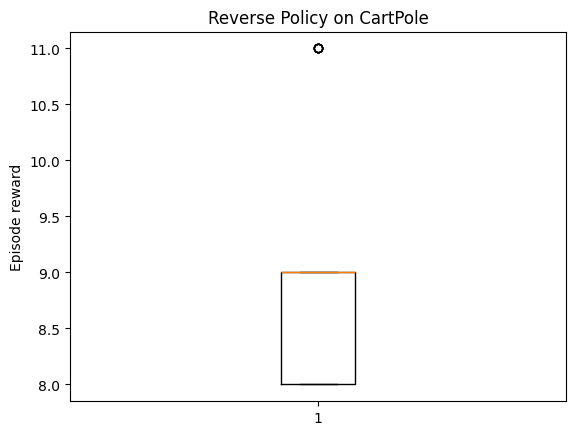

Mean reward: 8.735


In [142]:
# make a boxplot of rewards
plt.boxplot(episode_rewards)
plt.ylabel("Episode reward")
plt.title("Reverse Policy on CartPole")
plt.show()

print("Mean reward:", np.mean(episode_rewards))

#### 5) Modified Policy
**(POINTS: 2)** Full points for attempt and clear explanation.

Time to get creative! See if you can try a different policy that improves the mean reward. Clearly explain your strategy.

My strategy was to use a weighted approach to both the angle and angle velocity. I gave higher weight to the angle, which I prioritized. I then added in the angular velocity to account for the speed it was tipping over into the score. This would allow the model to adjust earlier before it tipped over. I used a lower weight and played with the weight.  The results gave me a mean reward of 100.

In [147]:

def better_policy(state):

    x, x_dot, theta, theta_dot = state


    score = (1.5 * theta) + (0.5 * theta_dot)
    # if score is positive, push cart left (action = 1)
    if score > 0:
        return 1
    else:
        # otherwise, push cart right (action = 0)
        return 0

In [148]:
episode_rewards = []

# Run 1000 episodes, each with up to 100 steps
for episode in range(1000):
    obs, info = env.reset()
    total_reward = 0
    for t in range(100):
        action = better_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:   # stop early if episode ends
            break
    episode_rewards.append(total_reward)

env.close()

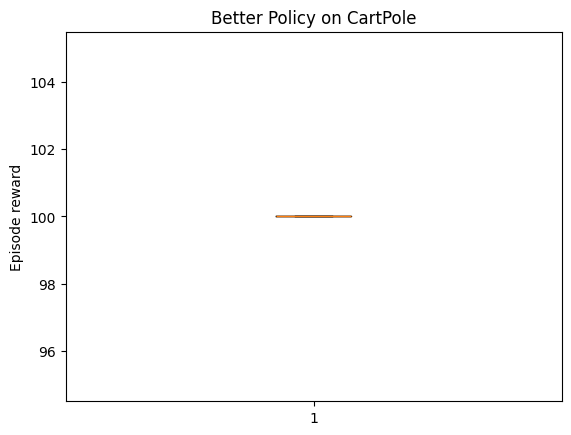

Mean reward: 100.0


In [149]:
# make a boxplot of rewards
plt.boxplot(episode_rewards)
plt.ylabel("Episode reward")
plt.title("Better Policy on CartPole")
plt.show()

print("Mean reward:", np.mean(episode_rewards))

---  

### Wrapup

This demo illustrated some basic ideas of reinforcement learning and got you started with OpenAI Gym.

We will revisit this example later, bringing in more tools for a better solution.

---
